In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import scipy.stats as sts


Bad key "text.kerning_factor" on line 4 in
/Users/juminichelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
## Importing data
dict_data = pd.read_csv("clean_data.csv") 
products = ["Apple", "Banana", "Tomato", "Potato", "Flour", "Rice", "Milk", "Butter", "Egg", "Chicken"]

input_data = {
    "price" : dict_data["Price"].tolist(),
    "neighborhood" : dict_data["Neighborhood"].tolist(),
    "grocery" : dict_data["Grocery Store"].tolist(),
    "product" : dict_data["Product"].tolist(),
    "product_count" : len(products),
    "grocery_count" : len(set(dict_data["Grocery Store"].tolist())),
    "neighborhood_count" : len(set(dict_data["Neighborhood"].tolist())),
    "row_count" : len(dict_data.index),
    "alpha_base" : 1.5,
    "beta_base" : 0.003,
    "alpha" : 4,
    "beta" : 4, 
    "loc_error": 0.1,
    "scale_error": 10}

## Model Specification

We must have priors over three parameters: the base price for each product, the multiplier for each store brand, and the multiplier for geographical location.

For the **base price**, we have as given that the price is a positive and continuous value, and that its support has to be broad, as we do not know the scales we are using (as we are using multiple cities as data points). We can have a better idea of the support by looking at the distribution of prices in the table in the code. Given these constraints, I will choose a gamma distribution for this prior, with parameters alpha and beta set to 1.5 and 0.003, respectively. 

The gamma distribution gives enough flexibilization on the support and form of the distribution over the parameters, allowing to cover all the prices using continuous variables. Moreover, the parameters chosen reflect the high distribution of low prices with low high prices.

For the prior of the **store brand multiplier**, we know the prior should be centered in 1, as it is a scale parameter. We also know that this is also a continuous variable. Nonetheless, our support is only over positive numbers, as there are no negative prices. Thus, I chose a gamma distribution with alpha of 4 and beta of 4, which has the mean of 1. I am setting a high hyperparameter as I am assuming low chances of a discrepancy between stores that is above 3.

Lastly, for the **grocery store multiplier**, given that it faces similar constraints as the neighborhood multiplier, I will use the same prior. There is no specific information about the grocery store multiplier that makes it different from the store brand multiplier. Nonetheless, it is important to remember that those are different distributions, with only equal parameters.

I am also adding an additional parameter, which is the error term. I am assuming a similar scenario with a regression: although I am assuming these three parameters will predict and model the prices we see, and the error term will capture the effect of other factors not taken into account in the model. Because it can be either positive or negative, and we have no information about the error, I am setting it to be a normal distribution, centered with mean 0 and standard deviation of 10, to be more consistent with the currency we have.

Thus, the distribution of the prices will be given by a normal distribution, with mean of *base price * grocery store multiplier * neighborhood multiplier*, and variance given by the error term.

In [3]:
stan_code = """

data {
    int<lower=1> row_count;             
    int<lower=1> product_count;              
    int<lower=1> grocery_count;             
    int<lower=1> neighborhood_count;              
    real<lower=0> price[row_count];     
    int<lower=0> product[row_count];  
    int<lower=0> grocery[row_count];     
    int<lower=0> neighborhood[row_count]; 
    real loc_error;           //error prior hyperparameter
    real scale_error;         //error prior hyperparameter 
    real<lower=0> alpha;         // prior hyperparameter 
    real<lower=0> beta;          // prior hyperparameter
    real<lower=0> alpha_base;         // prior hyperparameter 
    real<lower=0> beta_base;          // prior hyperparameter
}

parameters {
    real<lower=0> base_price[product_count];
    real<lower=0> neighborhoods_multiplier[neighborhood_count];
    real<lower=0> groceries_multiplier[grocery_count];
    real error;
}

model {
    // priors
    base_price ~ gamma(alpha_base,beta_base);
    neighborhoods_multiplier ~ gamma(alpha, beta);  
    groceries_multiplier ~ gamma(alpha, beta);
    error ~ normal(loc_error,scale_error);
    
    // likelihood function
    for(x in 1:row_count){
        price[x] ~ normal(base_price[product[x]] * neighborhoods_multiplier[neighborhood[x]]*groceries_multiplier[grocery[x]],error); 
    }   
}

"""

In [4]:
# Running the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7d12dd25454ae45f371043b71c49ce8 NOW.


In [5]:
# Extracting samples from the posterior
stan_results = stan_model.sampling(data=input_data)
posterior_samples = stan_results.extract()

In [6]:
# Showing the summary of the posterior
summary = stan_results.summary()

df_summary = pd.DataFrame(summary['summary'], 
                  columns=summary['summary_colnames'], 
                  index=summary['summary_rownames'])
df_summary.head(10)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
base_price[1],315.610055,2.675918,68.079097,200.832548,266.713279,310.549707,356.904513,471.474553,647.264710,1.003820
base_price[2],156.118129,1.394147,42.171028,86.770544,125.869257,152.036749,181.708081,248.389421,914.979739,1.004225
base_price[3],1280.083552,10.738337,264.650011,838.978105,1087.248676,1259.337768,1442.419488,1876.151641,607.392934,1.004300
base_price[4],742.664752,6.218363,154.434156,485.512800,632.484996,729.838308,837.661955,1092.350590,616.786014,1.003967
base_price[5],70.226464,0.707031,24.563105,29.700301,52.815671,67.271547,84.978591,125.995575,1206.952338,1.000910
base_price[6],136.880533,1.179038,35.988763,75.893873,111.548032,133.841079,158.668199,217.521563,931.703925,1.001586
base_price[7],233.949590,1.993244,51.821152,148.208810,197.116466,229.050518,264.699714,348.600521,675.916788,1.003374
base_price[8],183.367446,1.588004,44.828568,109.446508,151.310054,179.168642,209.866505,283.704482,796.904570,1.003469
base_price[9],208.466266,1.754154,48.392009,128.145253,174.058033,203.886802,237.437412,317.505270,761.047687,1.002770
base_price[10],340.265249,2.824637,73.273398,219.801095,285.905499,333.721597,385.986695,503.704831,672.926335,1.003476


## Analysis

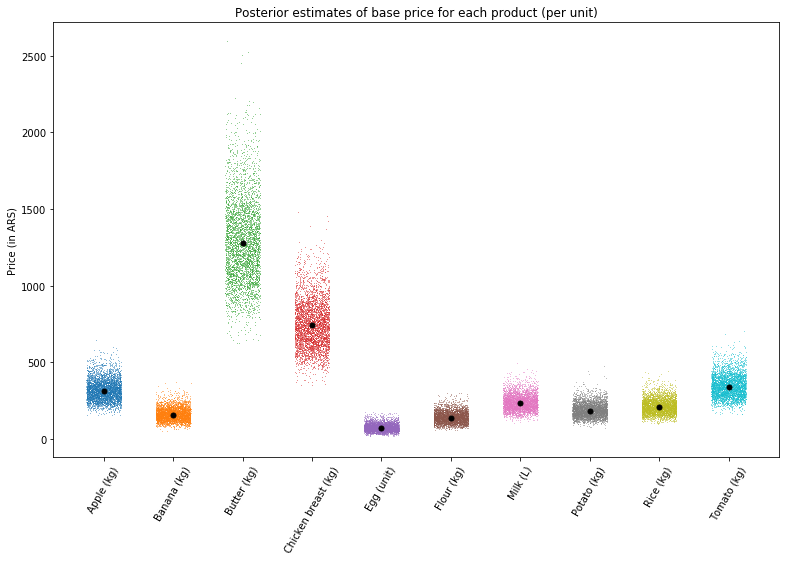

In [7]:
# plotting sampled data points from the stan models

plt.figure(figsize=(13, 8))
for i in range(len(products)):
    plt.plot(sts.uniform.rvs(loc=(i+1)-0.25,scale=0.5,  size=len(posterior_samples['base_price'])), posterior_samples['base_price'][:,i], ',', alpha=0.5)
    plt.plot((i+1), df_summary['mean'][('base_price['+str(i+1)+']')], marker='o', markersize=5, color="black")
plt.title("Posterior estimates of base price for each product (per unit)")
plt.ylabel("Price (in ARS)")
plt.xticks([1,2,3,4,5,6,7,8,9,10],
           ["Apple (kg)", "Banana (kg)", "Butter (kg)", "Chicken breast (kg)", "Egg (unit)", "Flour (kg)", "Milk (L)", "Potato (kg)", "Rice (kg)", "Tomato (kg)"])
plt.xticks(rotation=60)
plt.show()

It is important to acknowledge that these average prices reflect three cities around the globe: Taipei, Buenos Aires and San Francisco, with varying sample sizes. Thus, it does not necessarily reflect the average price in any specific cities, as having multiple cities might vary the estimates, upwards or downwards. We can see the difference across neighborhood more clearly when we see the estimates of neighborhood multipliers:

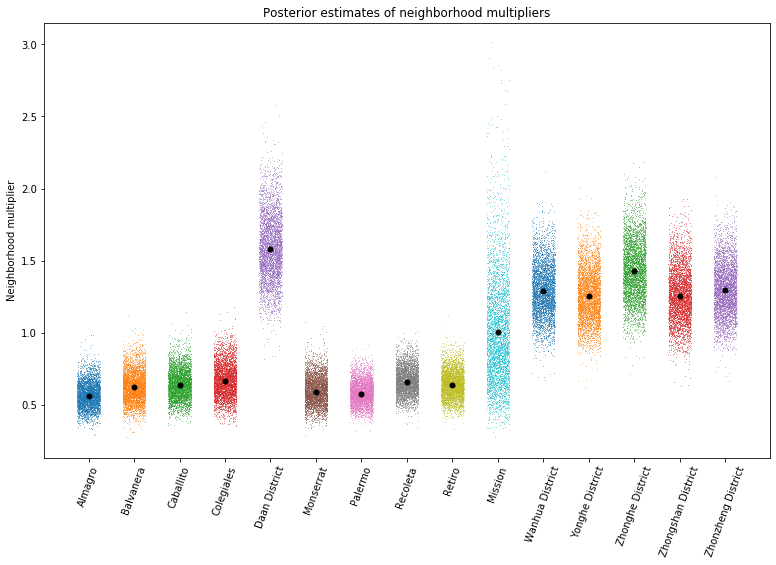

In [8]:
plt.figure(figsize=(13, 8))
for i in range(len((set(dict_data["Neighborhood"].tolist())))):
    plt.plot(sts.uniform.rvs(loc=(i+1)-0.25,scale=0.5,  size=len(posterior_samples['neighborhoods_multiplier'])), posterior_samples['neighborhoods_multiplier'][:,i], ',', alpha=0.5)
    plt.plot((i+1), df_summary['mean'][('neighborhoods_multiplier['+str(i+1)+']')], marker='o', markersize=5, color="black")
plt.title("Posterior estimates of neighborhood multipliers")
plt.ylabel("Neighborhood multiplier")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],["Almagro", "Balvanera", "Caballito", "Colegiales", "Daan District", "Monserrat", "Palermo", "Recoleta", 
 "Retiro", "Mission", "Wanhua District", "Yonghe District","Zhonghe District", "Zhongshan District", "Zhonzheng District", ])
plt.xticks(rotation=70)
plt.show()

Almagro, Balvanera, Caballito, Colegiales, Monserrat, Palermo, Recoleta and Retiro are neighborhoods in Buenos Aires, whereas Daan district, Wanhua district, Yonghe district, Zhonghe district, Zhongshan district and Zhongzheng district are Taipei neighborhoods. There is only one neighborhood represented in San Francisco, which is the Mission district.

It is important that we understand that the multipliers are taken into account the entire dataset. The consequences are that the variation in neighborhood multipliers within the same country are smaller, as compared to the neighborhoods in other countries, which is expected as the prices are expected to vary more across countries and the models are adjusted to reflect that. Thus, we can easily say that the prices of public goods are higher in these neighborhoods in Taipei as compared to the neighborhoods in Buenos Aires. If we compare Zhongzheng and Retiro (both two Minerva residence halls locations), the base price would be 62% of its price in Retiro and 132% of its price in Zhongzheng. It is also important to acknowledge that the model does not take into account purchasing power parity in any of the cities; thus, it can be the case that the prices are virtually the same when taking into account the average income of the city. Nonetheless, it would not be surprising if the prices for basic goods are higher in Taiwan than in Buenos Aires, as the geography of the former is much less favorable to agriculture than the latter.

Lastly, it is important to acknowledge that there were very few observations per neighborhood in locations outside Buenos Aires. Whereas data about seven supermarkets in Palermo were collected, the highest number of supermarket observations per neighborhood in Taipei were two. In San Francisco, only two supermarket data were collected. Thus, we can expect the estimates to be more accurate for Buenos Aires neighborhoods than Taipei and San Francisco. This can be even more clear when we look at the store brand multipliers:

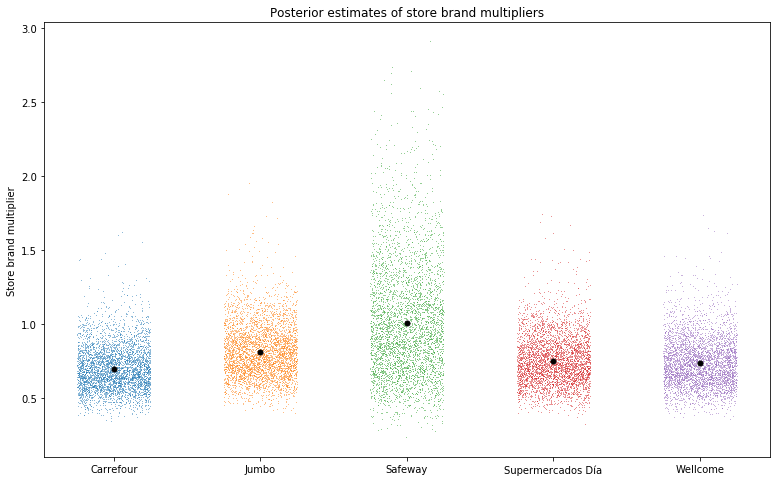

In [9]:
plt.figure(figsize=(13, 8))
for i in range(len((set(dict_data["Grocery Store"].tolist())))):
    plt.plot(sts.uniform.rvs(loc=(i+1)-0.25,scale=0.5,  size=len(posterior_samples['groceries_multiplier'])), posterior_samples['groceries_multiplier'][:,i], ',', alpha=0.5)
    plt.plot((i+1), df_summary['mean'][('groceries_multiplier['+str(i+1)+']')], marker='o', markersize=5, color="black")
plt.title("Posterior estimates of store brand multipliers")
plt.ylabel("Store brand multiplier")
plt.xticks([1,2,3,4,5],
           ["Carrefour", "Jumbo", "Safeway", "Supermercados Día", "Wellcome"])
plt.show()

In this case, it becomes clear the importance of gathering enough data across supermarkets in the variation of the posterior estimates (and therefore, on its average). As can be seen in the Figure, there is a lot more variation for the estimates for the posterior as opposed to the other supermarkets. Because only two Safeway brands were observed, there is more room for uncertainty which means more variation in the estimates.

Besides that, it is clear that all the prices seem to be negatively impacted by the store brand multiplier (with the exception of Safeway). The base price of any good seems to be 70% of its price in Carrefour, and 82% of its price in Jumbo. Lastly, we check whether there is a correlation between the average neighborhood multipliers and the average rent prices in the city of Buenos Aires. It is important to acknowledge that the rent prices used for this analysis are from 2016, and the current prices might have risen a lot given the economic and political instability that the country has been facing for the past few years. Nonetheless, it is expected that the prices have risen for all the neighborhoods and that it has not influenced the relationship between the neighborhoods (in
other words, the most expensive neighborhoods are probably still the most expensive ones, as the inflation had an effect in all neighborhoods), thus not influencing the correlation we want to analyze here.

If we compare the multipliers of the store brand and neighborhood, we can see that the prices are slightly more influenced by the latter than the former (keeping in mind all the data and model drawbacks previously discussed). We can see that by observing that the We can see in the figure below that there seem to be a very small positive correlation between the neighborhoods multiplier and the average rent price in Buenos Aires (r-squared:
.26). Again, it is important to remember that some neighborhoods have a lot more supermarket observations in some neighborhoods as compared to other ones, which might explain the small correlation.

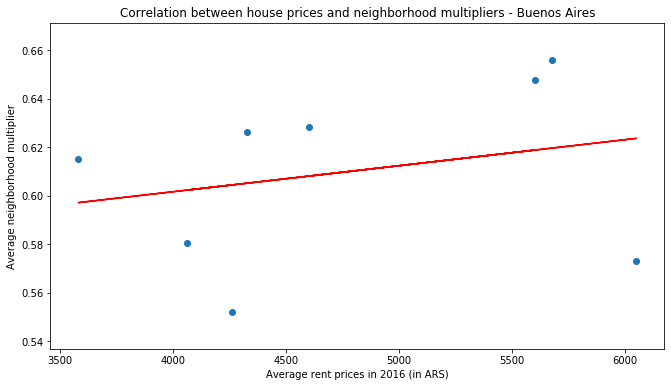

The r-squared of the correlation between the average rent prices in 2016 and average neighborhood multiplier is 0.25625032261329533.


In [10]:
# data for correlation
house_bsas = np.array([
    4260, # almagro
    3580, # balvanera
    4325, # caballito
    5600, # colegiales
    4060, # monserrat
    6050, # palermo
    5675, # recoleta
    4600]) # retiro

average_neighbor = [
    0.552192, # almagro
    0.614919, # balvanera
    0.626115, # caballito
    0.647510, # colegiales
    0.580685, # monserrat
    0.573007, # palermo
    0.655972, # recoleta
    0.628455] #retiro

# regression
regression = sts.linregress(house_bsas, average_neighbor)

#plotting
m=regression[0] #slope
b=regression[1] # intercept
plt.figure(figsize=(11, 6))
plt.scatter(house_bsas, average_neighbor)
plt.plot(house_bsas, m*house_bsas + b, color="red")
plt.title("Correlation between house prices and neighborhood multipliers - Buenos Aires")
plt.xlabel("Average rent prices in 2016 (in ARS)")
plt.ylabel("Average neighborhood multiplier")
plt.show()

print(f"The r-squared of the correlation between the average rent prices in 2016 and average neighborhood multiplier is {regression[2]}.")